In [28]:
from energyflow.archs.moment import EFN_moment
from energyflow.archs.efn import EFN

import numpy as np
import energyflow as ef

from energyflow.datasets import qg_jets
from energyflow.utils import data_split, to_categorical

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [29]:
# energyflow imports


################################### SETTINGS ##################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 total for full dataset
train, val, test = 75000, 10000, 15000
# train, val, test = 1000000, 200000, 200000

# network training parameters
num_epoch = 5
batch_size = 500

###############################################################################

# load data
X, y = qg_jets.load(train + val + test)

# ignore pid information
X = X[:,:,:3]

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

print('Finished preprocessing')

# do train/val/test split 
(z_train, z_val, z_test, 
 p_train, p_val, p_test,
 Y_train, Y_val, Y_test) = data_split(X[:,:,0], X[:,:,1:], Y, val=val, test=test)

Loaded quark and gluon jets
Finished preprocessing


In [30]:
architecture_types = ['moment', 'cumulant', 'mixed']

In [31]:
Phi_size=64
Phi_depth = 2
Phi_acts = 'LeakyReLU'


F_size = 64
F_depth = 3
F_acts = 'LeakyReLU'

output_dim = 2
output_act = 'softmax'

architecture_type = architecture_types[0]
order=2

loss = 'bce'
metrics = 'acc'

In [32]:
Phi_input_dim = 2
Phi_output_dim = 4

In [33]:
moment = EFN_moment({'Phi_mapping_dim' : [Phi_input_dim, Phi_output_dim],
                      'output_dim' : output_dim, 'output_act' : output_act,
                      'Phi_sizes' : [Phi_size for x in range(Phi_depth)], 'Phi_acts' : Phi_acts,
                      'F_sizes' : [F_size for x in range(F_depth)], 'F_acts': F_acts,
                      'order' : order , 'architecture_type': architecture_type,
                      'loss': loss,'metrics': metrics},  summary=True)

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
tdist0_0 (TimeDistributed)      (None, None, 64)     192         input_4[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_15 (LeakyReLU)      (None, None, 64)     0           tdist0_0[0][0]                   
__________________________________________________________________________________________________
tdist0_1 (TimeDistributed)      (None, None, 64)     4160        leaky_re_lu_15[0][0]             
___________________________________________________________________________________________

C:\Users\athis\Anaconda3\lib\site-packages\energyflow\archs\moment_layers.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  matrix = np.array([[1 for x in list(flatten_list(itmd_id_list[i:]))] for i in range(len(itmd_id_list))])


In [34]:
moment.fit([z_train, p_train], Y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=([z_val, p_val], Y_val),
        verbose=1)

Epoch 1/5
150/150 [==============================] - 2s 7ms/step - loss: 0.6191 - acc: 0.6520 - val_loss: 0.5764 - val_acc: 0.6977
Epoch 2/5
150/150 [==============================] - 1s 5ms/step - loss: 0.5743 - acc: 0.6981 - val_loss: 0.5655 - val_acc: 0.7065
Epoch 3/5
150/150 [==============================] - 1s 5ms/step - loss: 0.5561 - acc: 0.7139 - val_loss: 0.5409 - val_acc: 0.7293
Epoch 4/5
150/150 [==============================] - 1s 5ms/step - loss: 0.5364 - acc: 0.7349 - val_loss: 0.5359 - val_acc: 0.7333
Epoch 5/5
150/150 [==============================] - 1s 5ms/step - loss: 0.5287 - acc: 0.7405 - val_loss: 0.5249 - val_acc: 0.7454


In [35]:
#factorization
Phi_input_dims = [1,1]
Phi_output_dims = [2,2]
Phi_mapping_dim =[[Phi_input_dims[i],Phi_output_dims[i]] for i in range(2)]

factorized_Phi_size = 32

In [36]:
rapidity_train = p_train[:,:,0]
azim_train = p_train[:,:,1]

rapidity_val = p_val[:,:,0]
azim_val = p_val[:,:,1]

rapidity_test = p_test[:,:,0]
azim_test = p_test[:,:,1]

In [37]:
factorized_moment = EFN_moment({'Phi_mapping_dim' : Phi_mapping_dim,
                      'output_dim' : output_dim, 'output_act' : output_act,
                      'Phi_sizes' : [factorized_Phi_size for x in range(Phi_depth)], 'Phi_acts' : Phi_acts,
                      'F_sizes' : [F_size for x in range(F_depth)], 'F_acts': F_acts,
                      'order' : order , 'architecture_type': architecture_type,
                      'loss': loss,'metrics': metrics},  summary=True)

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
tdist0_0 (TimeDistributed)      (None, None, 32)     64          input_5[0][0]                    
__________________________________________________________________________________________________
tdist1_0 (TimeDistributed)      (None, None, 32)     64          input_6[0][0]                    
___________________________________________________________________________________________

In [38]:
factorized_moment.fit([z_train, rapidity_train, azim_train], Y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=([z_val, rapidity_val, azim_val], Y_val),
        verbose=1)

Epoch 1/5
150/150 [==============================] - 2s 6ms/step - loss: 0.6241 - acc: 0.6601 - val_loss: 0.5790 - val_acc: 0.7036
Epoch 2/5
150/150 [==============================] - 1s 5ms/step - loss: 0.5683 - acc: 0.7021 - val_loss: 0.5566 - val_acc: 0.7124
Epoch 3/5
150/150 [==============================] - 1s 5ms/step - loss: 0.5513 - acc: 0.7190 - val_loss: 0.5391 - val_acc: 0.7351
Epoch 4/5
150/150 [==============================] - 1s 6ms/step - loss: 0.5366 - acc: 0.7309 - val_loss: 0.5416 - val_acc: 0.7289
Epoch 5/5
150/150 [==============================] - 1s 5ms/step - loss: 0.5274 - acc: 0.7390 - val_loss: 0.5266 - val_acc: 0.7413


In [39]:
# get predictions on test data
preds = moment.predict([z_test, p_test], batch_size=1000)

# get ROC curve
efn_fp, efn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

# get area under the ROC curve
auc = roc_auc_score(Y_test[:,1], preds[:,1])
print()
print('UNFACTORIZED MODEL AUC:', auc)



UNFACTORIZED MODEL AUC: 0.8058685251620654


In [40]:
# get predictions on test data
preds = factorized_moment.predict([z_test, rapidity_test, azim_test], batch_size=1000)

# get ROC curve
f_efn_fp, f_efn_tp, f_threshs = roc_curve(Y_test[:,1], preds[:,1])

# get area under the ROC curve
auc = roc_auc_score(Y_test[:,1], preds[:,1])
print()
print('FACTORIZED MODEL AUC:', auc)


FACTORIZED MODEL AUC: 0.8087144785388021


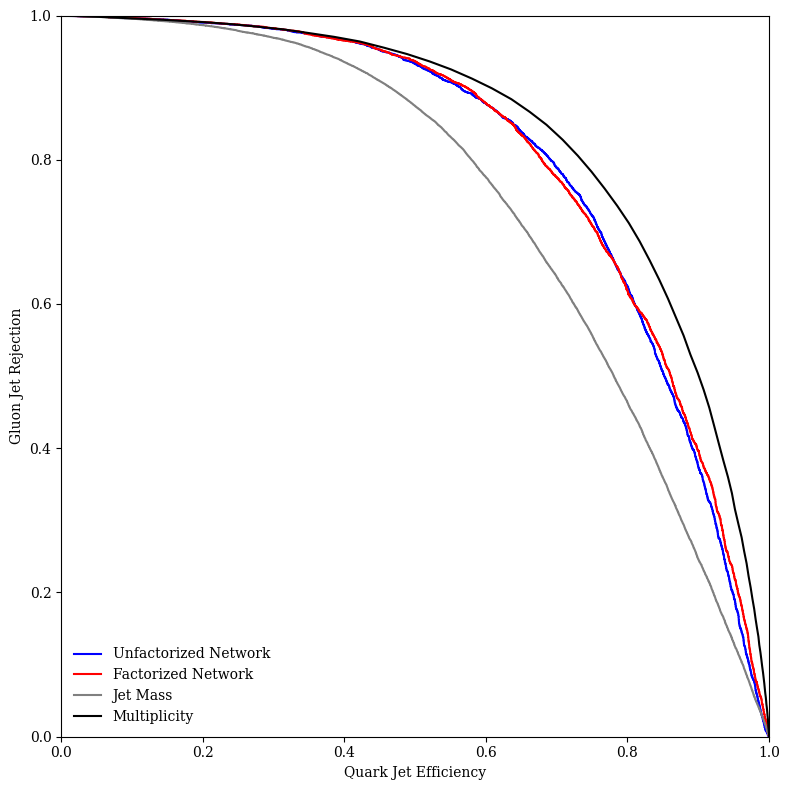

In [41]:
# some nicer plot settings 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

fig, axes = plt.subplots(1, 1, figsize=(8,8))

######################### ROC Curve Plot #########################
    # get multiplicity and mass for comparison
masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

# plot the ROC curves
#our networks
axes.plot(efn_tp, 1-efn_fp, '-', color='blue', label='Unfactorized Network')
axes.plot(f_efn_tp, 1-f_efn_fp, '-', color='red', label='Factorized Network')
# mass/multiplicity
axes.plot(mass_tp, 1-mass_fp, '-', color='grey', label='Jet Mass')
axes.plot(mult_tp, 1-mult_fp, '-', color='black', label='Multiplicity')

# axes labels
axes.set_xlabel('Quark Jet Efficiency')
axes.set_ylabel('Gluon Jet Rejection')

# axes limits
axes.set_xlim(0, 1)
axes.set_ylim(0, 1)

# make legend and show plot
axes.legend(loc='lower left', frameon=False)
plt.show()

In [82]:
# Plotting Phi Functions

#constructing rapidity-azimuthal plane
R = 0.5
grid_size = 200
x = np.linspace(-R,R, grid_size) #rapidity
y = np.linspace(-R, R, grid_size) #azimuthal angle
X_,Y_ = np.meshgrid(x,y)

colors = ['Reds', 'Oranges', 'Greens', 'Blues', 'Purples', 'Greys']


# Getting the phi functions
#"Returns a list of length equal to the number of factorized inputs. Each element is a function of each factorized variable. 
#Output dimension is defined in Phi_input_mapping argument when constructing the network."
unfactorized_phi_function = moment.phi_functions()[0]
phi_rapid, phi_azim  = factorized_moment.phi_functions()


# Formatting inputs
rapidity_input = np.expand_dims(X_, axis=-1) #If inputs are function G(x) of rapidity, redefine rapidity_input = G(rapidity_input) 
azim_input = np.expand_dims(Y_, axis=-1) #If inputs are function G(y) of azimuth, redefine azim_input = G(azim_input) 
unfactorized_input = np.concatenate( [rapidity_input, azim_input], axis=-1)

#compute outputs
unfactorized_output = unfactorized_phi_function(unfactorized_input)

rapidity_output = phi_rapid(rapidity_input)
azim_output = phi_azim(azim_input)
factorized_output = np.concatenate([rapidity_output, azim_output], axis=-1)

Z_list = [unfactorized_output, factorized_output]

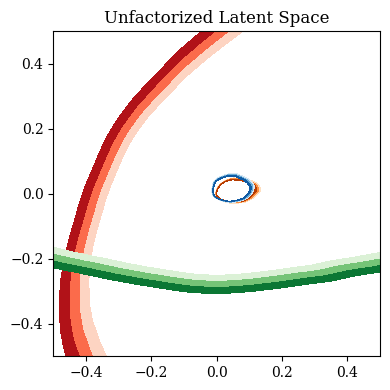

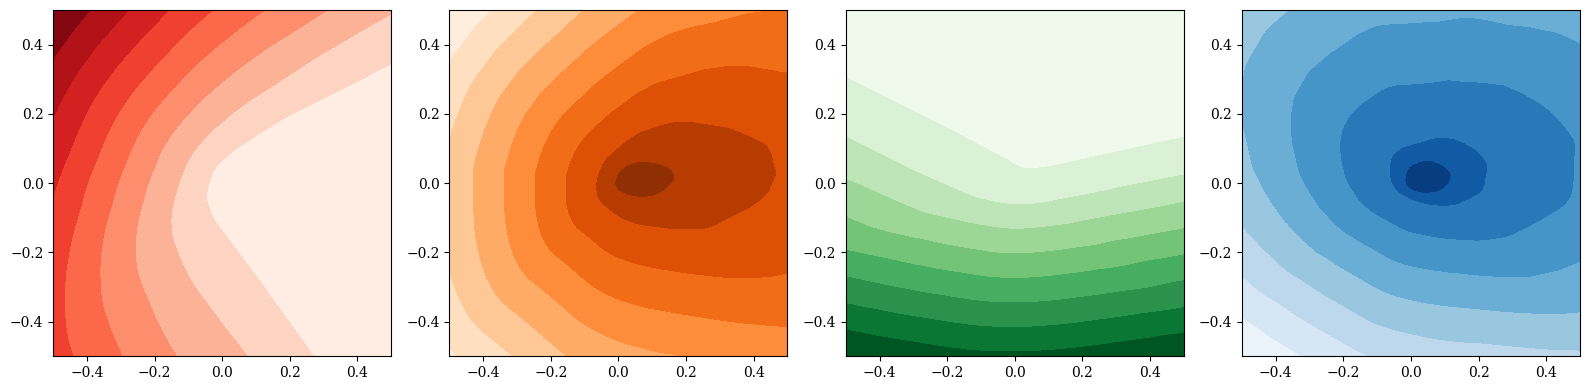

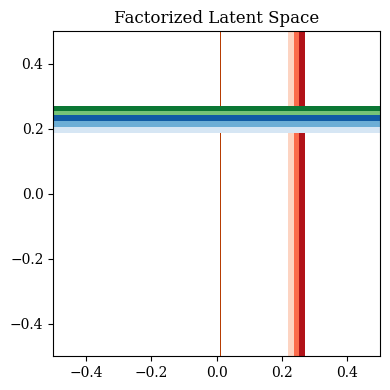

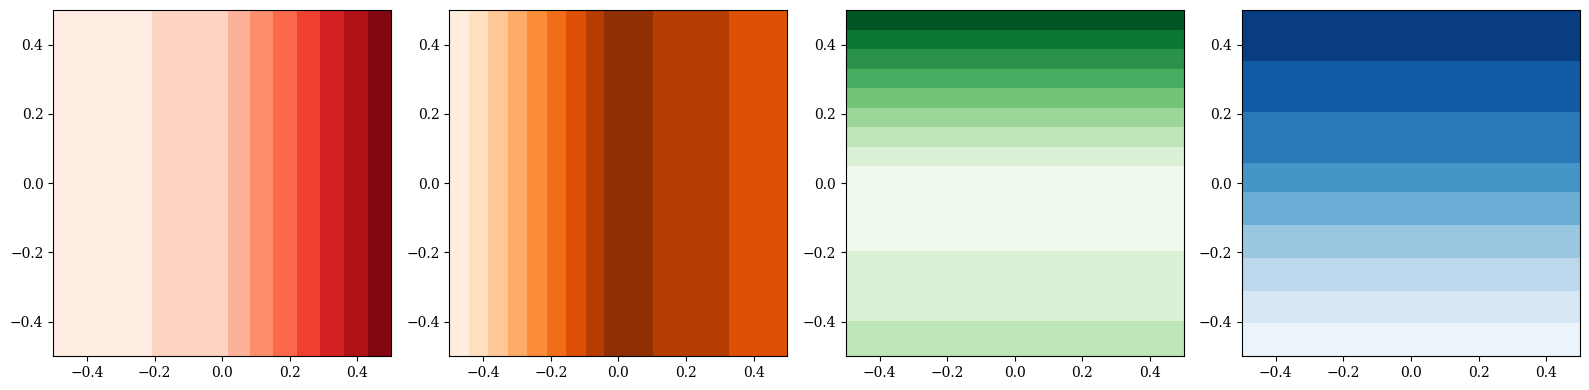

In [83]:
names = ['Unfactorized Latent Space', 'Factorized Latent Space']
for k,Z in enumerate(Z_list):
    latent_dim = Z.shape[-1]


    # some nicer plot settings 
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['figure.autolayout'] = True



    # plot filters
    fig1, ax1 = plt.subplots(1, 1, figsize=(4,4))
    ax1.set_title(names[k])
    grads = np.linspace(0.45, 0.55, 4)
    for i in range(latent_dim):
        z = Z[:,:,i]
        ax1.contourf(X_, Y_, z/np.max(z), grads, cmap=colors[i%len(colors)])


    #plot individual phis
    fig2, ax2 = plt.subplots(1, latent_dim, figsize=(4*latent_dim,4))
    for i in range(latent_dim):
        z = Z[:,:,i]
        grads = np.linspace(np.min(z),np.max(z.flatten()), 10)
        ax2[i].contourf(X_,Y_, z, grads, cmap=colors[i%len(colors)])
plt.show()

In [84]:
# plotting moments
unfactorized_moments_function = moment.moments()
factorized_moments_function = factorized_moment.moments()

unfactorized_output = unfactorized_moments_function(unfactorized_input)
factorized_output = factorized_moments_function([rapidity_input, azim_input])

Z_list = [unfactorized_output, factorized_output]

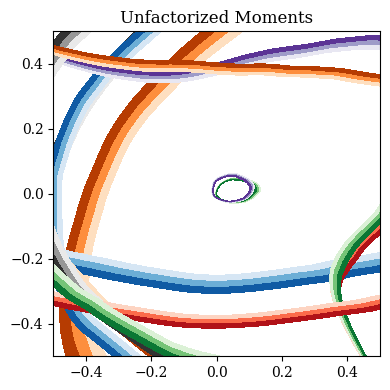

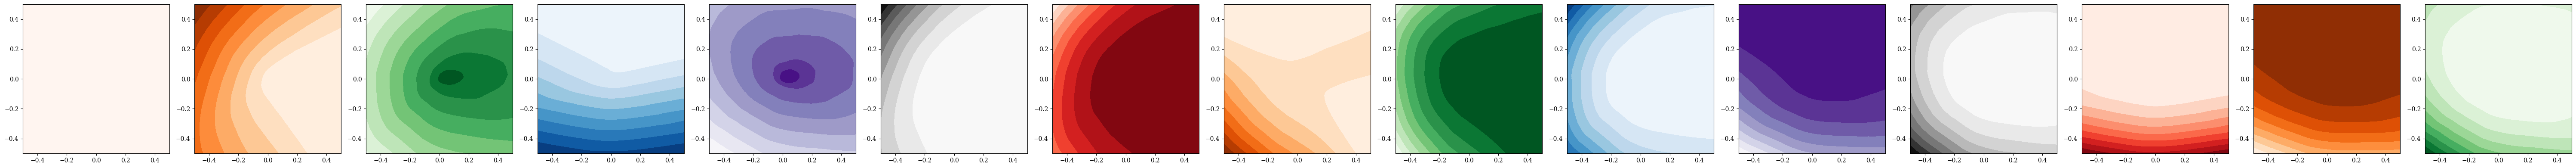

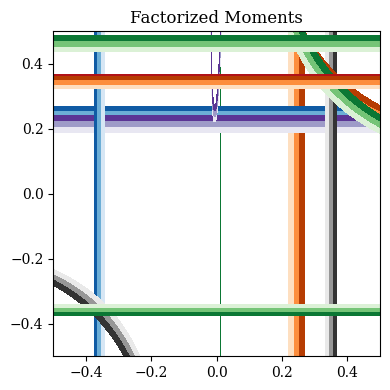

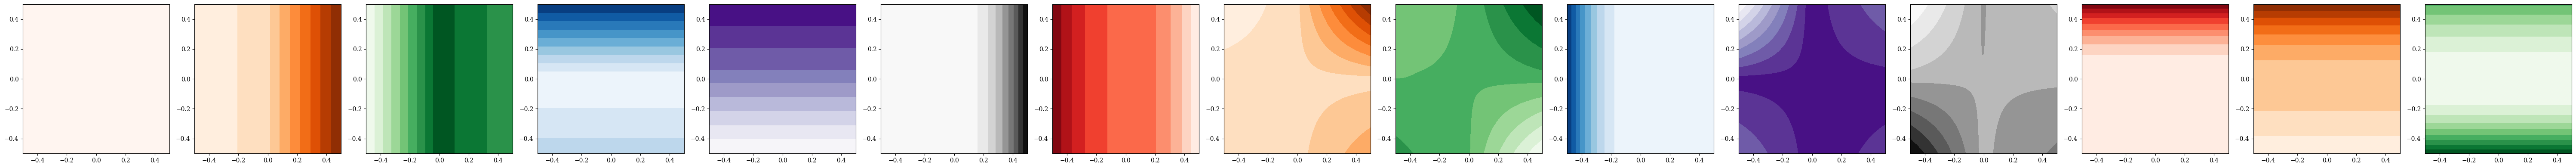

In [85]:
names = ['Unfactorized Moments', 'Factorized Moments']
epsilon = 10*np.finfo(float).eps 
#If a moment is constant, use epsilon so that python can define a contour even if the function is constant

for k,Z in enumerate(Z_list):
    latent_dim = Z.shape[-1]


    # some nicer plot settings 
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['figure.autolayout'] = True



    # plot filters
    fig1, ax1 = plt.subplots(1, 1, figsize=(4,4))
    grads = np.linspace(0.45, 0.55, 4)
    for i in range(latent_dim):
        z = Z[:,:,i]
        ax1.contourf(X_, Y_, z/np.max(z), grads, cmap=colors[i%len(colors)])
    ax1.set_title(names[k])
    
    #plot individual phis
    fig2, ax2 = plt.subplots(1, latent_dim, figsize=(4*latent_dim,4))
    for i in range(latent_dim):
        z = Z[:,:,i]
        grads = np.linspace(np.min(z),np.max(z) + epsilon, 10)
        ax2[i].contourf(X_,Y_, z, grads, cmap=colors[i%len(colors)])
plt.show()